In [1]:
import os
import pandas as pd
import numpy as np
from IPython import get_ipython

# envs
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.getcwd()

'/home/runner/work/update/update'

starting to check:  BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb
previous log found: 2022-08-25 12:28
difference in execution is: 0.3228 days
needed difference to execute: 0.5 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


starting to check:  BoliGrafica/_bots/twitter_bo-indicadores/SDSN/sdsn_map_post.ipynb
previous log found: 2022-08-25 12:28
difference in execution is: 0.3228 days
needed difference to execute: 0.625 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  BoliGrafica/_bots/twitter_bo-indicadores/SDSN/sdsn_map_post.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


starting to check:  BoliGrafica/_bots/twitter_bo-indicadores/Banco_Mundial_World_Bank/wbgapi_indicator_post.ipynb
previous log found: 2022-08-25 12:28
difference in execution is: 0.3228 days
needed difference to execute: 0.5833 days
Executtion:  False ... DID NOT EXECUTE NOR LOG
Finished:  BoliGrafica/_bo

ModuleNotFoundError: No module named 'ipynb'

... t'was a FAILURE. :(
New log entry successful!


Finished:  Greenhouse_Data/_bots/twitter_country_post/country_of_the_day.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


starting to check:  Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb
previous log found: 2022-08-25 12:28
difference in execution is: 0.3228 days
needed difference to execute: 0.25 days
Executtion:  True ... STARTING NOW
envs failed to load
Iran, Islamic Republic of greenhouse gas emission data and figures 👇

If you like this kind of stuff be sure to check out my website for many more datasets and figures! Thank you and have a wonderful day 🤖
Starting success list []
 > Searching for 20 tweets containing "greenhouse gas emissions Saint Lucia"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list []
 > Searching for 20 tweets containing "greenhouse gas emissions Mali"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list []
 > Searching for 20 tweets containing "greenhouse gas e

['country_data/ESP_Spain/figures/ESP_relative_totals.png',
 'country_data/ESP_Spain/figures/ESP_GCP_Country_Highlight.png',
 'country_data/ESP_Spain/figures/ESP_GCP_1.png',
 'country_data/ESP_Spain/figures/ESP_Minx_top20_subsectors.png']

 > saved and selected 4 images
 > TWEET SUCCESSFUL!!
success list: [True] 



Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Timor-Leste"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Costa Rica"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Zambia"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions El Salvador"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Zimbabwe"
 > found 0 tweets
 > empty df: NEXT ITERATION

Starting success list [True]
 > Searching for 20 tweets containing "greenhouse gas emissions Philippines"
 > found 3 tweets
 > days of invalidity: 20
 > Number of inv

['country_data/PHL_Philippines/figures/PHL_relative_totals.png',
 'country_data/PHL_Philippines/figures/PHL_GCP_Country_Highlight.png',
 'country_data/PHL_Philippines/figures/PHL_GCP_1.png',
 'country_data/PHL_Philippines/figures/PHL_Minx_top20_subsectors.png']

 > saved and selected 4 images
 > TWEET SUCCESSFUL!!
success list: [True, True] 





 FINISHED WHILE LOOP


 FINISHED WHILE LOOP
... t'was a SUCCESS! :)
New log entry successful!


Finished:  Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


starting to check:  Greenhouse_Data/random_fig/random_fig.ipynb
previous log found: 2022-08-24 18:22
difference in execution is: 1.0772 days
needed difference to execute: 1 days
Executtion:  True ... STARTING NOW


/tmp/ipykernel_1701/520225399.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='random_daily_fig.png'>
  open("random_daily_fig.png", "wb").write(response.content)


random_fig generated
... t'was a SUCCESS! :)
New log entry successful!


Finished:  Greenhouse_Data/random_fig/random_fig.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


starting to check:  Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb
previous log found: 2022-08-23 18:14
difference in execution is: 2.0827 days
needed difference to execute: 2 days
Executtion:  True ... STARTING NOW


/tmp/ipykernel_1701/1726371239.py:4: ResourceWarning: unclosed file <_io.BufferedWriter name='Figure_Styles.ipynb'>
  open("Figure_Styles.ipynb", "wb").write(response.content)
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.


current figure and save dpi = 160; current single fig size = (8, 4)


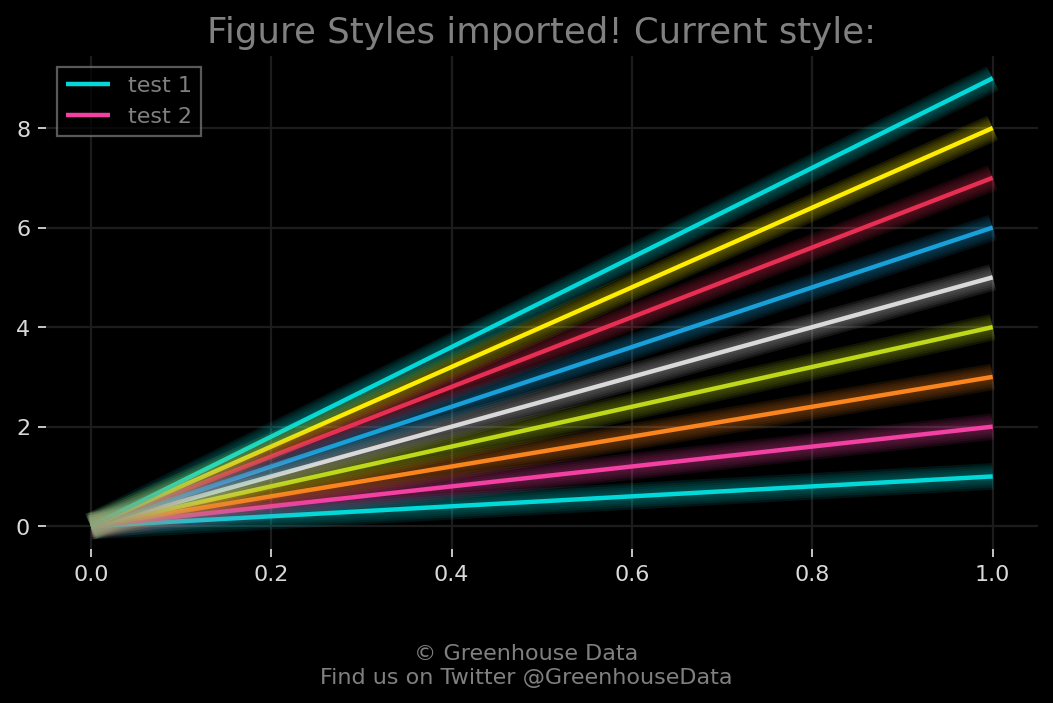

styles imported!
CO2 NEW UPDATES:  False
CH4 NEW UPDATES:  False
N2O NEW UPDATES:  False
No update


findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Manjari'] not found. Falling back to DejaVu Sans.


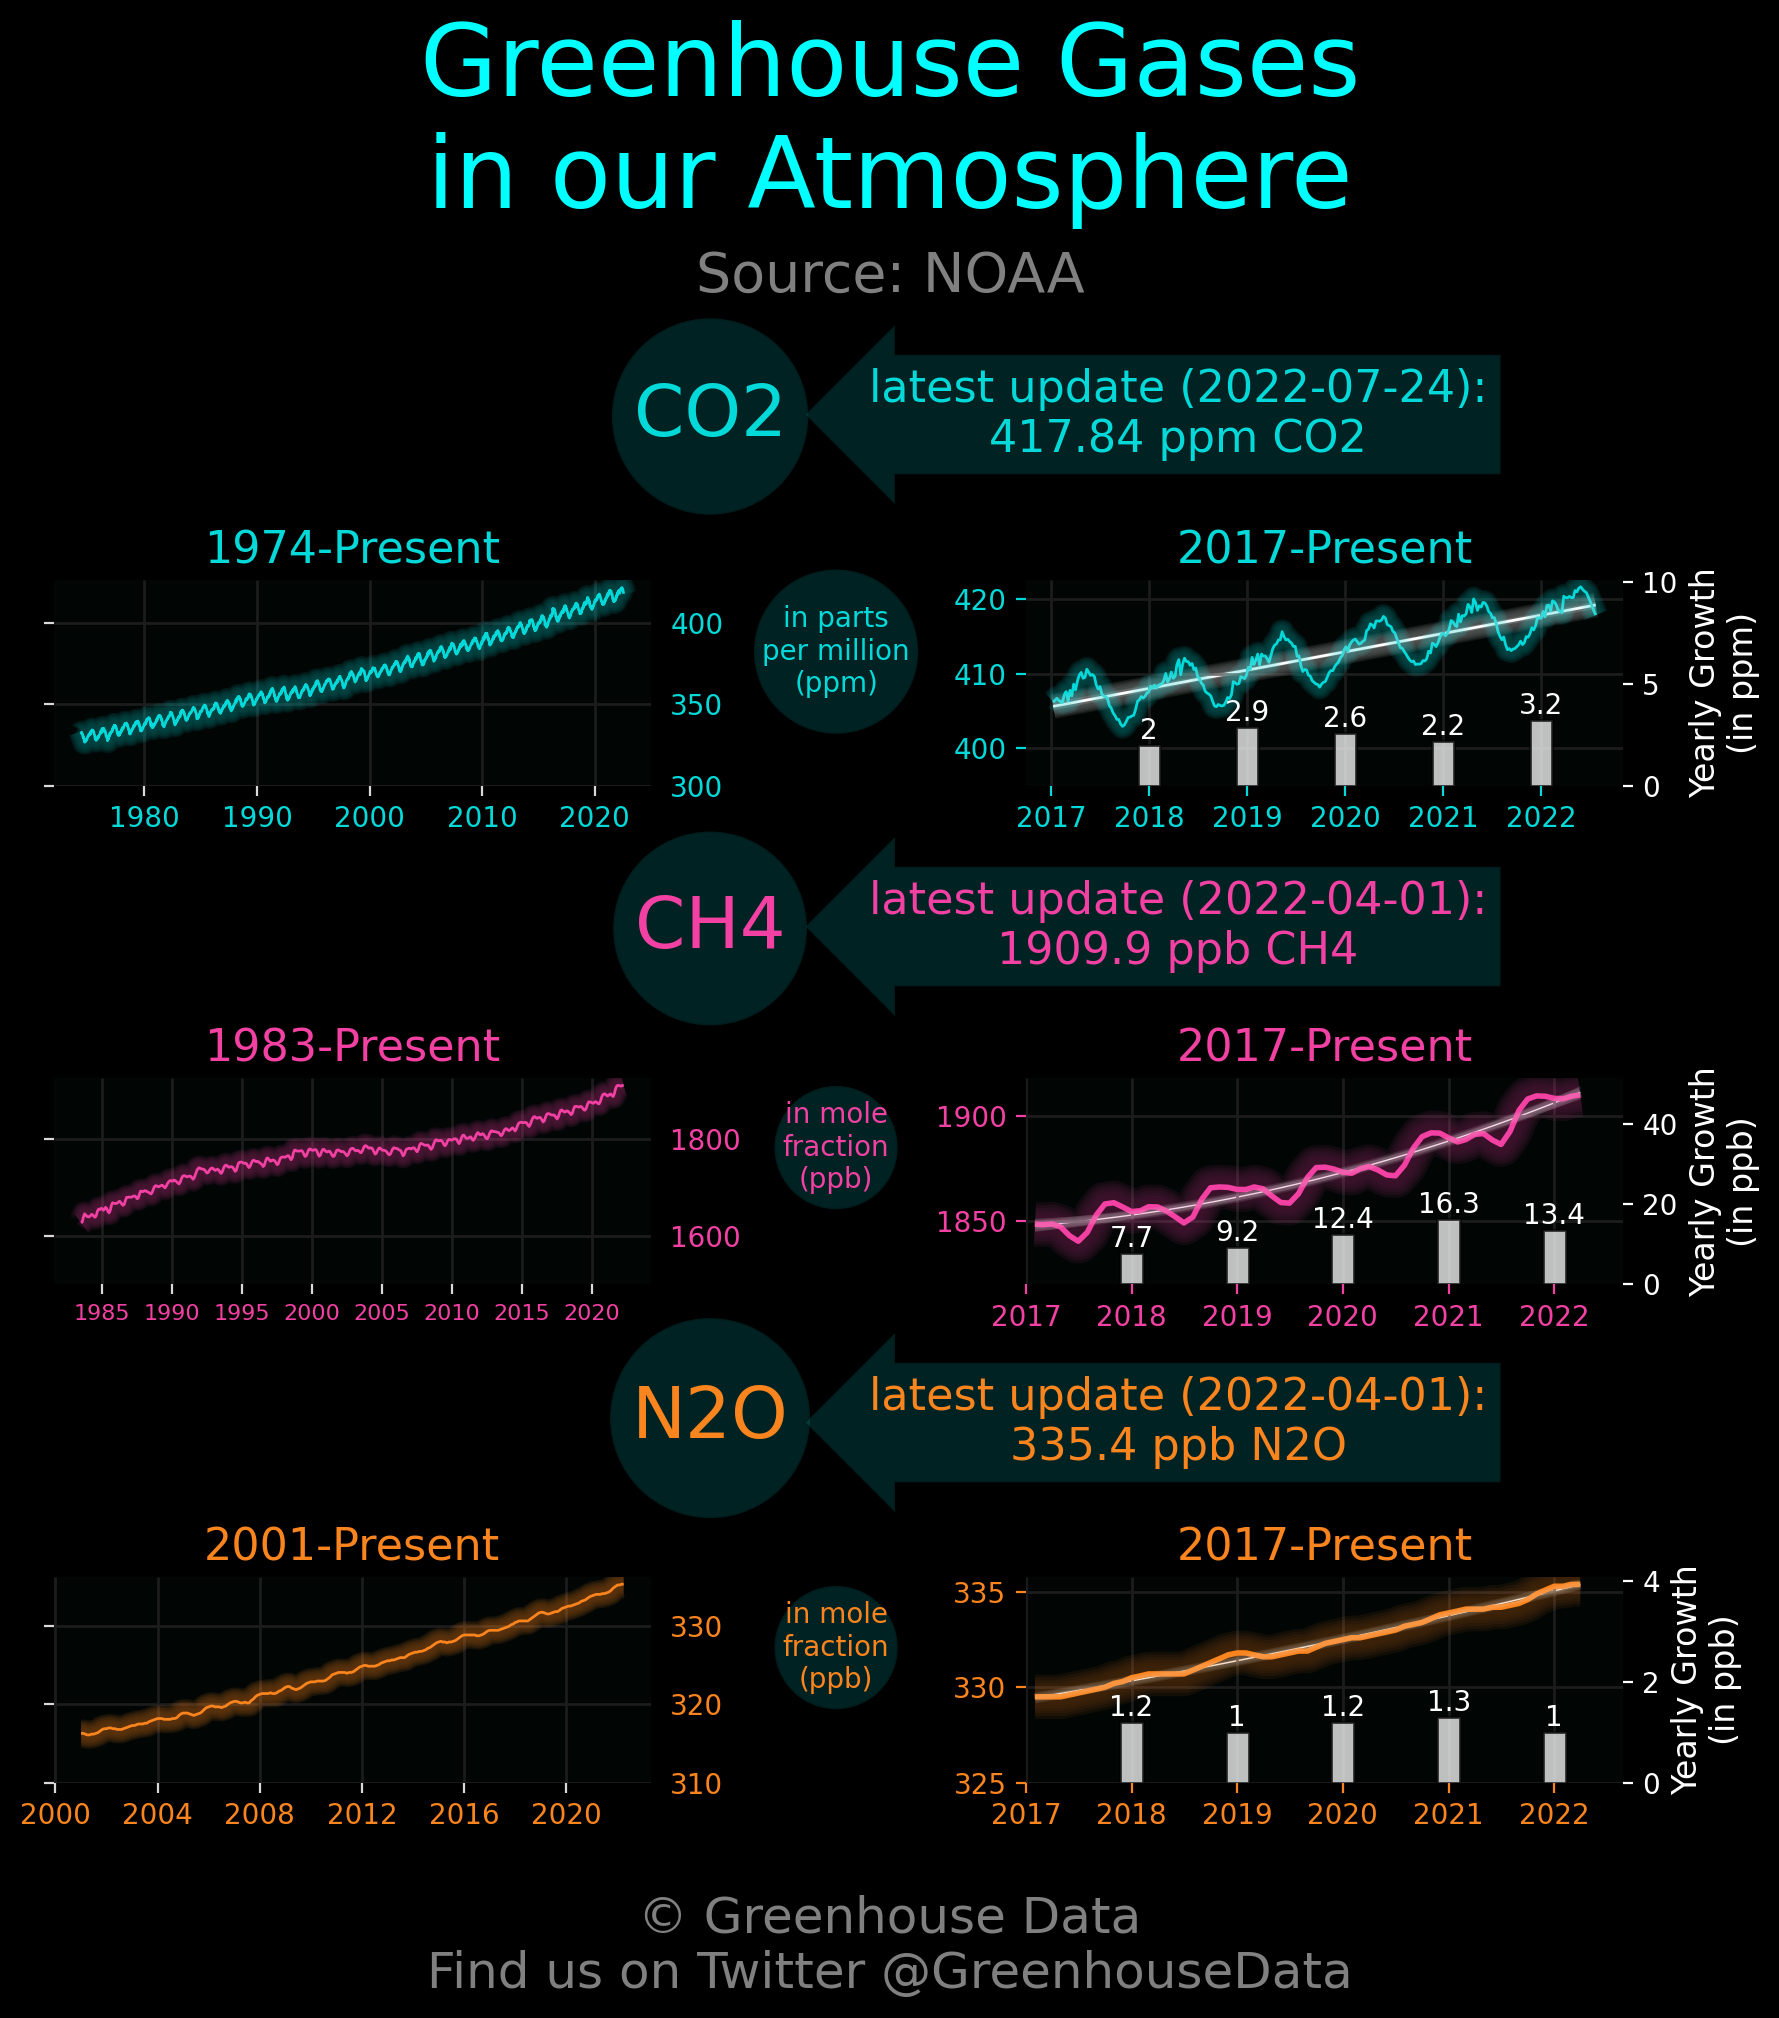

... t'was a SUCCESS! :)
New log entry successful!


Finished:  Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb 

😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋


🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻
               FINITO
🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻


In [3]:
def SCHEDULED_RUNNER(notebook_path, schedule_in_days = None):
    
    print("starting to check: ", notebook_path)
    


    # if there is no schedule, run immediately
    if schedule_in_days == None:
        EXECUTE = True
        


    # else run on a schedule based on last execution time
    else:
        # check log
        log = pd.read_csv("log.csv", index_col=0)
        try:
            last_executed = log.loc[notebook_path]["last_executed"]
            print(f"previous log found: {last_executed}")
        except:
            print("no log found (first time?) - creating dummy entry (year 2000)")
            log.loc[notebook_path] = ["2002-07-16 18:32",np.nan]
            
            # try again
            last_executed = log.loc[notebook_path]["last_executed"]
            
        # get time difference in days
        import datetime
        now = datetime.datetime.now()
        last_executed = datetime.datetime.strptime(last_executed, '%Y-%m-%d %H:%M')
        diff_seconds = now - last_executed
        diff_days = diff_seconds.total_seconds() / 60 /60 /24
        print(f"difference in execution is: {round(diff_days,4)} days")
        print(f"needed difference to execute: {round(schedule_in_days,4)} days")
        
        # check diff
        if diff_days > schedule_in_days:
            EXECUTE = True
        else:
            EXECUTE = False
            




    # EXECUTE?


    # EXECUTE TRUE
    if EXECUTE == True:
        print("Executtion: ", str(EXECUTE), "... STARTING NOW")

        # go to folder to run script locally
        folder_path = notebook_path.split("/")[:-1]
        os.chdir("/".join(folder_path))

        # try to run script, if it fails, it fails
        try:
            get_ipython().run_line_magic("run", notebook_path.split("/")[-1])
            status = "... t'was a SUCCESS! :)"
            print(status)
        except:
            status = "... t'was a FAILURE. :("
            print(status)

        # go back to root repository
        os.chdir("".join(["../"] * len(folder_path)))
        
        
        # log
        log.loc[notebook_path] = [datetime.datetime.now().strftime("%Y-%m-%d %H:%M"), status]
        log.to_csv("log.csv")
        print("New log entry successful!\n\n")




    # EXECUTE FALSE
    elif EXECUTE == False:
        print("Executtion: ", str(EXECUTE), "... DID NOT EXECUTE NOR LOG")



    print("Finished: ", notebook_path, "\n\n😋😋😋😋😋😋😋😋 NEXT 😋😋😋😋😋😋😋😋😋\n\n")
    pass




########################################################
###################### SCHEDULE #######################
########################################################




# ##### BOLIGRAFICA #####
SCHEDULED_RUNNER(notebook_path = "BoliGrafica/_bots/twitter_covid_replies/covid_reply.ipynb", schedule_in_days= 12/24)
SCHEDULED_RUNNER(notebook_path = "BoliGrafica/_bots/twitter_bo-indicadores/SDSN/sdsn_map_post.ipynb", schedule_in_days=15/24)
SCHEDULED_RUNNER(notebook_path = "BoliGrafica/_bots/twitter_bo-indicadores/Banco_Mundial_World_Bank/wbgapi_indicator_post.ipynb", schedule_in_days=14/24)

###### GREENHOUSE DATA #####
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/_bots/twitter_country_post/country_of_the_day.ipynb", schedule_in_days = 1)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/_bots/twitter_greenhouse_summon/greenhouse_summon.ipynb", schedule_in_days = 6/24)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/random_fig/random_fig.ipynb", schedule_in_days = 1)    
SCHEDULED_RUNNER(notebook_path = "Greenhouse_Data/NOAA_updates/NOAA_updates.ipynb", schedule_in_days = 2)


print("🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻\n               FINITO\n🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻🐻")